In [2]:
# import useful libraries
import numpy as np #
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from time import time
from sklearn.metrics import roc_auc_score


# Import the supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#disable warnings
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



In [5]:
data_train = pd.read_csv("census.csv")
data_test = pd.read_csv("test_census.csv").drop('Unnamed: 0',1)
#make a copy of data_train to overwrite during feature engineering
train = data_train[:]

In [8]:
# Total number of records
n_records = train.shape[0]

# Print the results
print("Total number of records: {}".format(n_records))

Total number of records: 45222


In [9]:
data_train.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [10]:
# Number of records where individual's income is more than $50,000
n_greater_50k = train[train.income == '>50K' ].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = train[train.income == '<=50K' ].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records)*100 ,2)

# Print the results
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [11]:
# transform target into new variable called income:
income=data_train.income.map({'<=50K': 0, '>50K':1})
income.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

In [12]:
# check how many unique values each feature has:
for column in data_train.columns:
    print(column, len(train[column].unique()))

age 74
workclass 7
education_level 16
education-num 16
marital-status 7
occupation 14
relationship 6
race 5
sex 2
capital-gain 121
capital-loss 97
hours-per-week 96
native-country 41
income 2


In [13]:
categorical = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 
               'race', 'sex', 'native-country']
continues = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']

Skew for  age 0.5328158942555792
Skew for  capital-gain 11.789002180291192
Skew for  capital-loss 4.516304152981587
Skew for  hours-per-week 0.34054514378520867
Skew for  education-num -0.3106209464770189


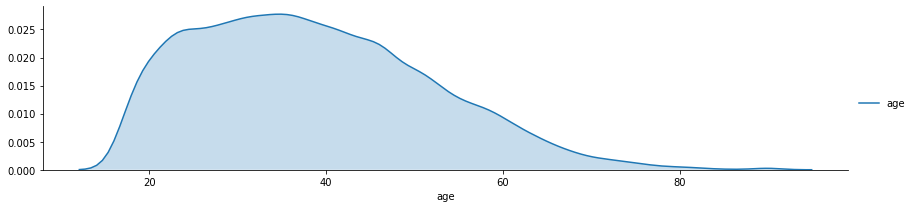

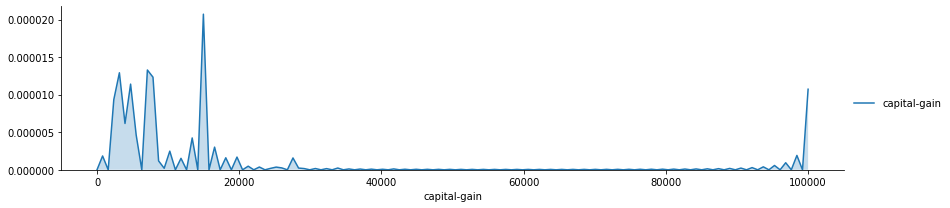

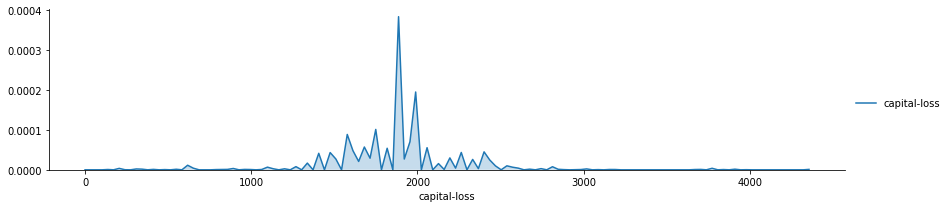

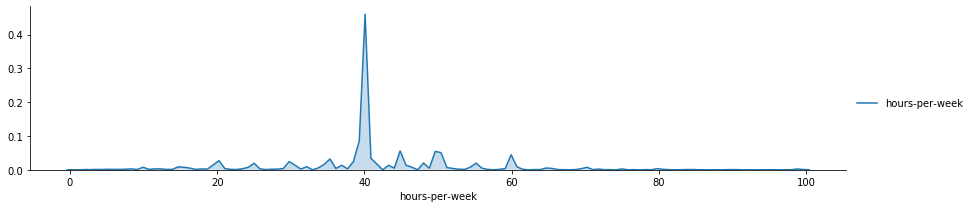

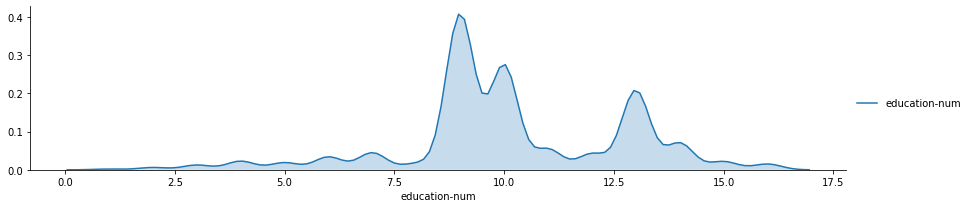

In [14]:
# plot disctribution and check skewness:
for column in continues:
    a = sns.FacetGrid(train, aspect=4 )
    a.map(sns.kdeplot, column, shade= True )
    a.add_legend()
    print('Skew for ',str(column), train[column].skew())

Skew for  capital-gain 3.082385920215176
Skew for  capital-loss 4.271194769830899


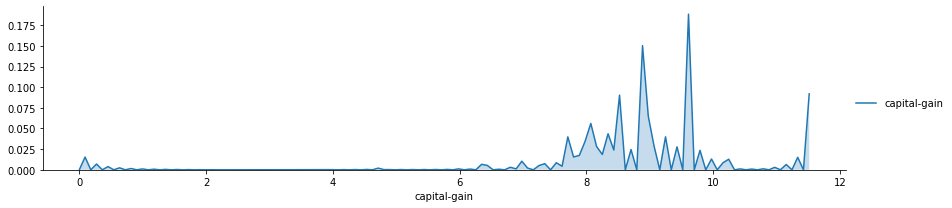

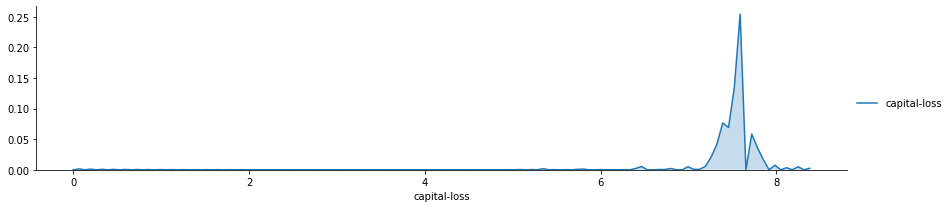

In [15]:
skewed = ['capital-gain', 'capital-loss']
# Log-transform the skewed features (create function to use later for test set)
def log_transform(data):
    return data[skewed].apply(lambda x: np.log(x + 1))
    
train[skewed] = log_transform(train)

# Visualize the new log distributions
for column in skewed:
    a = sns.FacetGrid(train, aspect=4 )
    a.map(sns.kdeplot, column, shade= True )
    a.add_legend()
    print('Skew for ',str(column), train[column].skew())

In [16]:
from sklearn.preprocessing import MinMaxScaler
#normalizing numerical features. Create function to use later on test data

def normalize(data):
    
    scaler = MinMaxScaler()
    data=scaler.fit_transform(data[continues])
    return data

train[continues]= normalize(train)
train.head(100)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.000000,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.122449,United-States,<=50K
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.000000,0.397959,United-States,<=50K
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.000000,0.397959,United-States,<=50K
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.000000,0.397959,Cuba,<=50K
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.000000,0.397959,United-States,<=50K
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.000000,0.153061,Jamaica,<=50K
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.448980,United-States,>50K
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.000000,0.500000,United-States,>50K
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.000000,0.397959,United-States,>50K


In [17]:
# One-hot encode thedata using pandas.get_dummies()
features_final = pd.get_dummies(train.drop(['income'],1))

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


103 total features after one-hot encoding.


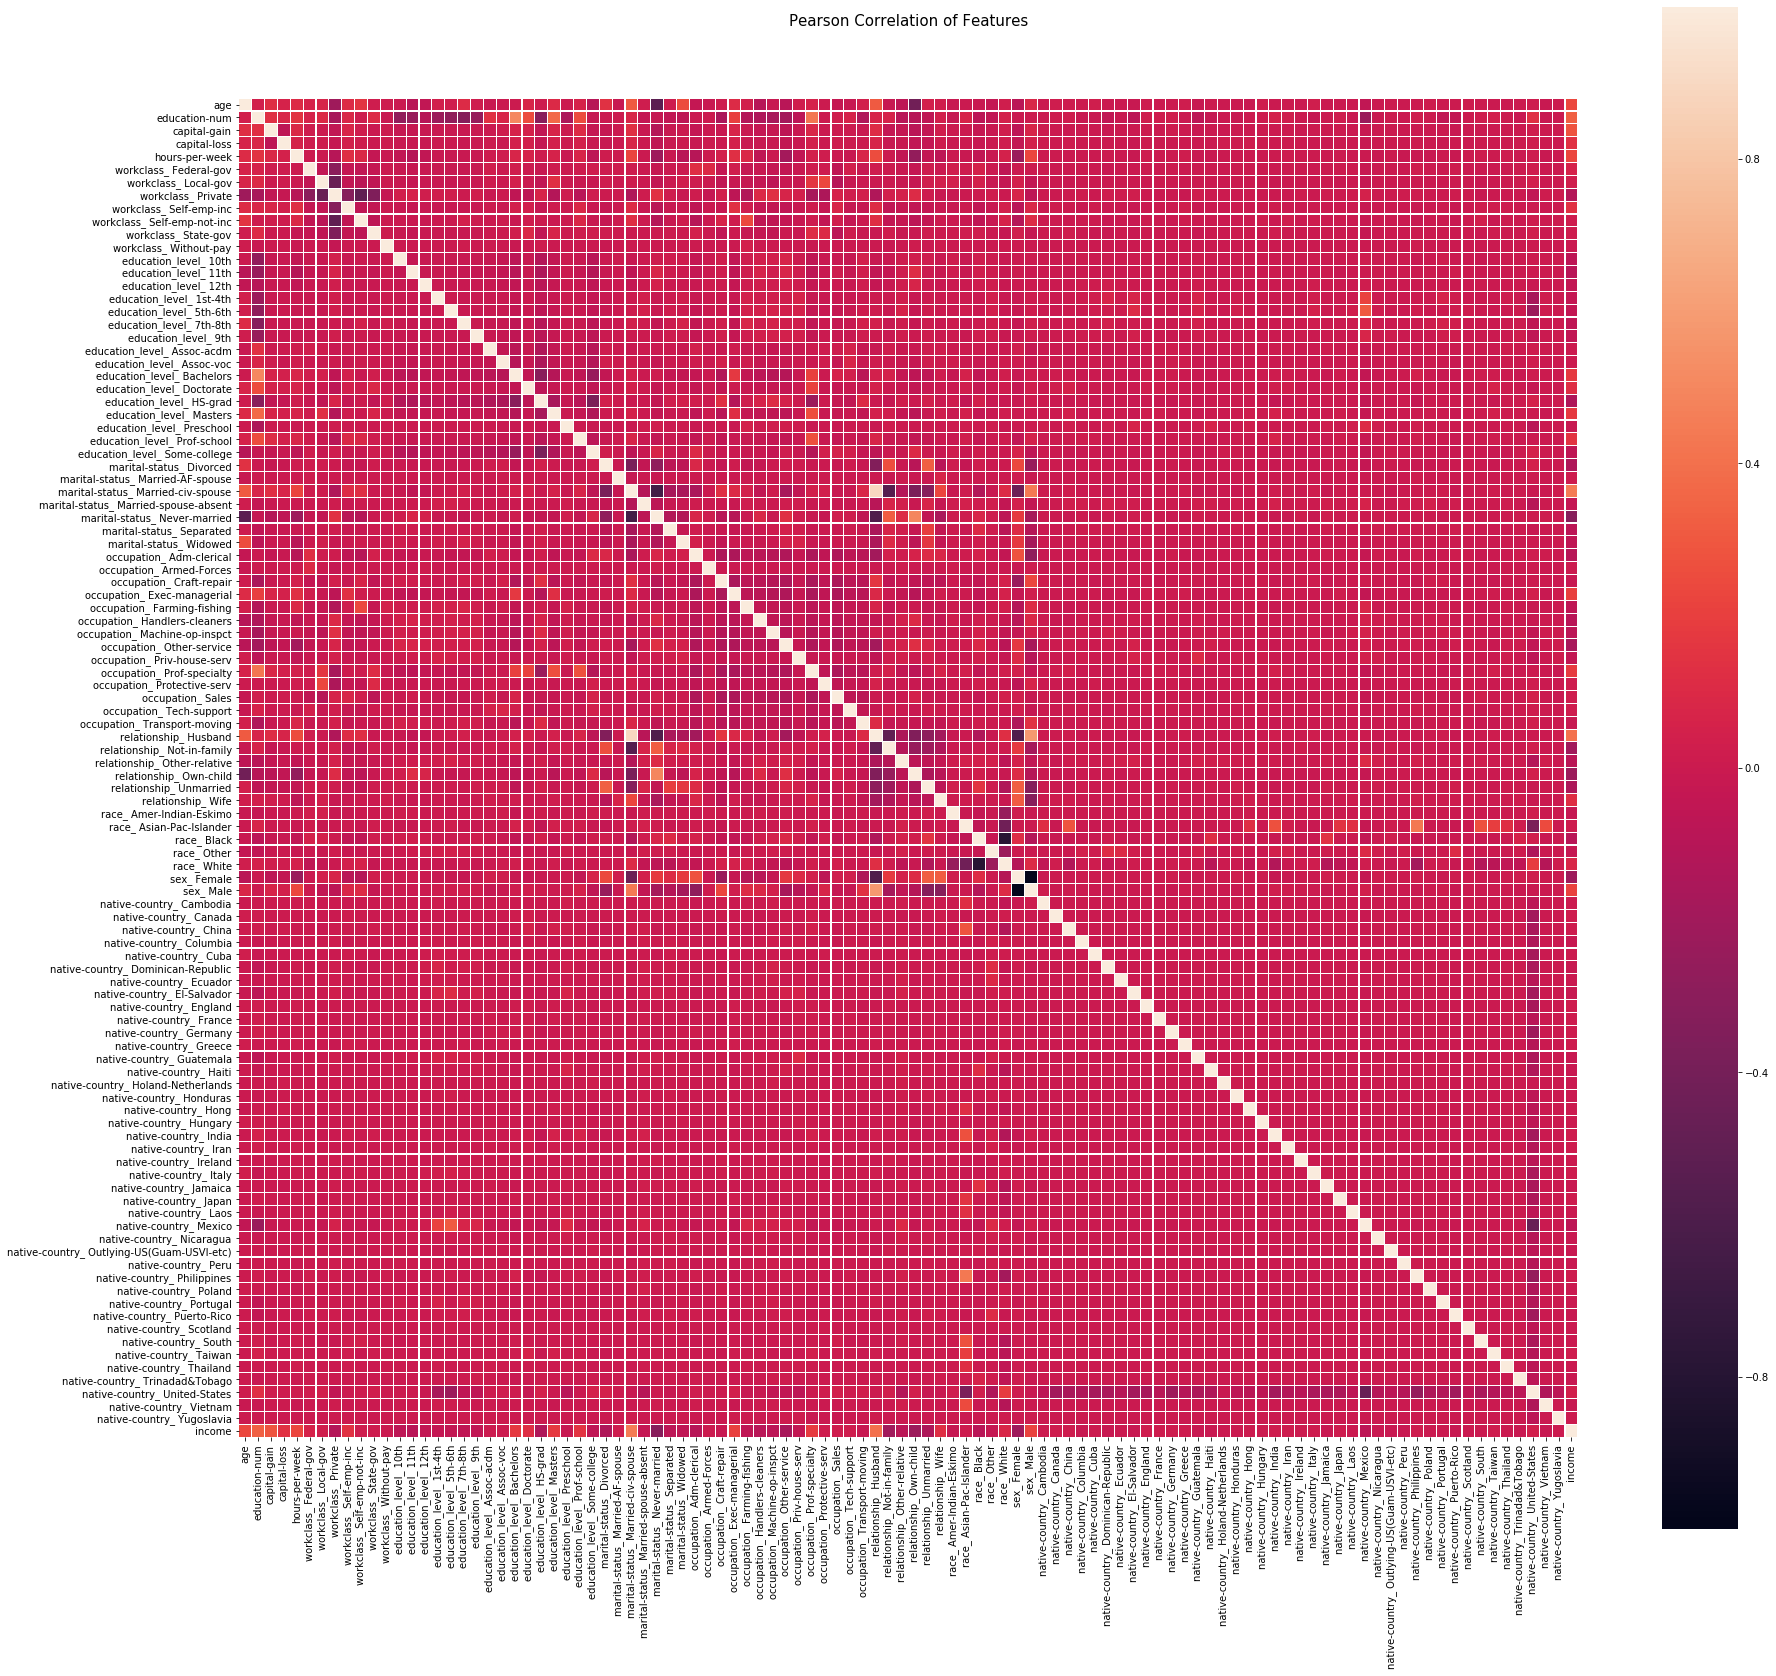

In [18]:
# check correlation between features: 
data = pd.concat([features_final, income], axis =1)
plt.figure(figsize=(30,28))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white')

In [19]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_val.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [20]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 2, figsize = (18,10))

    # Constants
    bar_width = 1
    colors = ['r','g','b','c', 'm', 'y']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'roc_train',  'pred_time', 'roc_test']):

                ax[j//2, j%2].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("ROC-AUC Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("ROC-AUC Score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("ROC-AUC Score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("ROC-AUC Score on Testing Set")
       
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    ax[1, 0].legend(handles = patches)
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [21]:
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features testing set
       - y_val: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data 
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['roc_train'] = roc_auc_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['roc_test'] = roc_auc_score(y_val, predictions_test)
              
    # Return the results
    return results

In [22]:
random_state =42
n_estimators =100

# Initialize the three models
clf_A = GaussianNB()
clf_B = KNeighborsClassifier()
clf_C = LogisticRegression(random_state= random_state)
clf_D = RandomForestClassifier(random_state= random_state, n_estimators = n_estimators)
clf_E = GradientBoostingClassifier(n_estimators = n_estimators, random_state = random_state)
clf_F = AdaBoostClassifier(n_estimators = n_estimators, random_state = random_state)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_val, y_val)

In [23]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV

In [24]:
clf = AdaBoostClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': range(20,1021,100)}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer,  verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  5.3min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7716

Optimized Model
------
Final ROC-AUC on the validation data: 0.7913
Final ROC-AUC on the training data: 0.7998
Optimal parameters: {'n_estimators': 1020}


In [25]:

clf = AdaBoostClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = { 'n_estimators': range(1000,1501,100)}

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer,  verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.8min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7716

Optimized Model
------
Final ROC-AUC on the validation data: 0.7911
Final ROC-AUC on the training data: 0.7995
Optimal parameters: {'n_estimators': 1200}


In [26]:
clf = AdaBoostClassifier(n_estimators=4000,random_state = random_state, learning_rate = 0.5)
clf.fit(X_train, y_train)
best_predictions_val_ab = clf.predict(X_val)
best_predictions_train_ab = clf.predict(X_train)
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val_ab)))
print("Final ROC-AUC on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train_ab)))

Final ROC-AUC on the validation data: 0.7900
Final ROC-AUC on the training data: 0.7986


In [27]:
#fit model with optimal parameters found during gridsearch:
clf_AB = AdaBoostClassifier(n_estimators=1200,random_state = random_state)
clf_AB.fit(X_train, y_train)
# predict outcome using predict_probe instead of predict function:
probs_train_ab = clf_AB.predict_proba(X_train)[:, 1]
probs_val_ab = clf_AB.predict_proba(X_val)[:, 1]
print("score train: {}".format(roc_auc_score(y_train, probs_train_ab)))
print("score validation: {}".format(roc_auc_score(y_val, probs_val_ab)))

score train: 0.9301209823821555
score validation: 0.926913215578629


In [28]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {  'n_estimators': range(20,101,20),
                'learning_rate':[0.2],
                'min_samples_split': [500],
                'min_samples_leaf' : [50],
                'max_depth' : [8],
                'subsample' : [0.8]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer,verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   55.8s finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.7960
Final ROC-AUC on the validation data: 0.8155
Optimal parameters: {'learning_rate': 0.2, 'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 500, 'n_estimators': 80, 'subsample': 0.8}


In [29]:
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed
parameters = {'max_depth':range(2,12,2), 
              'min_samples_split':range(100,601,100),
              'n_estimators': [80],
              'learning_rate':[0.2],                
              'min_samples_leaf' : [50],
              'subsample' : [0.8]
              }

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer,  verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.3min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.7983
Final ROC-AUC on the training data: 0.8133
Optimal parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 80, 'subsample': 0.8}


In [30]:
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'min_samples_leaf':range(10,71,10),
              'max_depth': [6], 
              'min_samples_split': [200],
              'n_estimators': [80],
              'learning_rate':[0.2],
              'subsample' : [0.8]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer, verbose=1, n_jobs =-1)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  2.2min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.7983
Final ROC-AUC on the validation data: 0.8133
Optimal parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 80, 'subsample': 0.8}


In [31]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
              'min_samples_leaf': [50],
              'max_depth': [6], 
              'min_samples_split': [200],
              'n_estimators': [80],
              'learning_rate':[0.2]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer, verbose=1, n_jobs =-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.7983
Final ROC-AUC on the validation data: 0.8133
Optimal parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 80, 'subsample': 0.8}


In [32]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'subsample':[0.8],
              'min_samples_leaf': [50],
              'max_depth': [6], 
              'min_samples_split': [200],
              'n_estimators': range(140, 241, 20),
              'learning_rate':[0.1]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer, verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.5min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.8007
Final ROC-AUC on the validation data: 0.8151
Optimal parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 180, 'subsample': 0.8}


In [33]:
clf = GradientBoostingClassifier(random_state = random_state)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'subsample':[0.8],
              'min_samples_leaf': [50],
              'max_depth': [6], 
              'min_samples_split': [200],
              'n_estimators': range(360, 401, 20) ,
              'learning_rate':[0.05]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring= scorer, verbose=1, n_jobs =-1)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions_val = best_clf.predict(X_val)
best_predictions_train = best_clf.predict(X_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC on validation data: {:.4f}".format(roc_auc_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val)))
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
print("Optimal parameters:", grid_obj.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  4.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  7.1min finished
Unoptimized model
------
ROC-AUC on validation data: 0.7764

Optimized Model
------
Final ROC-AUC on the validation data: 0.7991
Final ROC-AUC on the validation data: 0.8157
Optimal parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 200, 'n_estimators': 380, 'subsample': 0.8}


In [39]:
clf_GB = GradientBoostingClassifier(random_state = random_state, subsample = 0.8, min_samples_leaf = 50,
              max_depth = 6, min_samples_split = 200, n_estimators = 180, learning_rate = 0.1 )
clf_GB.fit(X_train, y_train)

best_predictions_val_gb = clf_GB.predict(X_val)
best_predictions_train_gb = clf_GB.predict(X_train)
print("Final ROC-AUC on the validation data: {:.4f}".format(roc_auc_score(y_val, best_predictions_val_gb)))
print("Final ROC-AUC on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train_gb)))

Final ROC-AUC on the validation data: 0.8007
Final ROC-AUC on the training data: 0.8151


In [40]:
probs_train_gb = clf_GB.predict_proba(X_train)[:, 1]
probs_val_gb = clf_GB.predict_proba(X_val)[:, 1]
print("score train: {}".format(roc_auc_score(y_train, probs_train_gb)))
print("score test: {}".format(roc_auc_score(y_val, probs_val_gb)))

score train: 0.9390206372088248
score test: 0.9278291960058876


In [44]:
X_test = data_test[:]

In [45]:
# fill missing values for numeric variables with approximatelly gaussian dictribution:
for col in ['age', 'education-num', 'hours-per-week']:
    X_test[col]= X_test[col].fillna(data_train[col].mean())

# fill missing values for numeric variables with skewed dictribution:
for col in ['capital-gain', 'capital-loss']:
    X_test[col]= X_test[col].fillna(data_train[col].median())

#fill missing categorical values with most freaquent category:
for col in categorical:
    X_test[col]= X_test[col].fillna(data_train.groupby([col])[col].count().sort_values(ascending=False).index[0])

In [46]:
X_test[skewed] = log_transform(X_test)

#scale continues variables:
X_test[continues]= normalize(X_test)

# One-hot encode thedata using pandas.get_dummies()
X_test_final = pd.get_dummies(X_test)

# Print the number of features after one-hot encoding
encoded = list(X_test_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


In [ ]:
best_model = clf_GB
test = pd.read_csv("test_census.csv")

test['id'] = test.iloc[:,0] 
test['income'] = best_model.predict_proba(X_test_final)[:, 1]

test[['id', 'income']].to_csv("submissionGB.csv", index=False)